# Objective
Demonstrate recover of HR from BART Model

In [11]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt

In [41]:
importlib.reload(ssf)

<module 'simsurv_func' from '/home/twj8/pymc_bart/simsurv_func.py'>

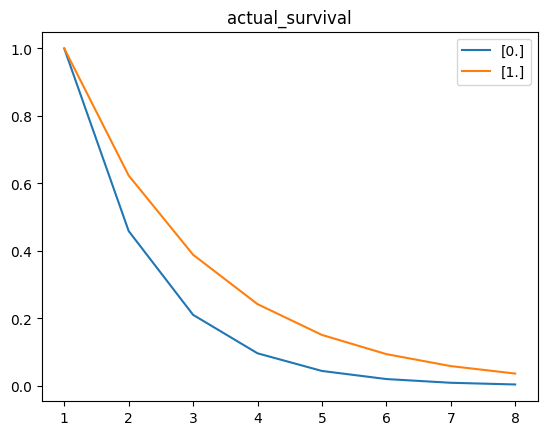

cens_calc: 0.0     
t_mean: 2.09     
t_max: 7.0
hazard rate 1 [0.47237 0.47237 0.47237]
hazard rate 0 [0.7788 0.7788 0.7788]
HR t-series = [0.6065357 0.6065357 0.6065357]


In [12]:
OUTPUTS = "outputs"
ALPHA = 1
LAMBDA = "np.exp(-.25 - .5*x_mat[:,0])"
N = 100
# T = 30
X_VARS = 1
CENS_SCALE = 5# 40
CENS_IND = False

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                N=N, 
                x_vars=X_VARS,
                a = ALPHA,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False)


# Get information of X vars
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
# calculate censored components
event_calc, cens_calc = ssf.get_status_perc(status) 
# Get the t mean and max
t_mean, t_max = ssf.get_event_time_metric(t_event)
# Get the training matrix
train = ssf.get_train_matrix(x_mat, t_event, status)
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T+1, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

# get unique x_mat
x_unique = np.unique(x_mat, return_index=True)
sv_unique = sv_mat[x_unique[1],:]
hz_unique = np.round(hz_mat[x_unique[1],:],5) 

HR_unique = hz_unique[1]/hz_unique[0]
# HR_times = np.arange(0,T,np.floor(T/4), dtype="int")
HR_times = np.array((np.ceil(T.shape[0]/4) * np.array([1,2,3])), dtype="int")
print(f"hazard rate 1 {hz_unique[1][HR_times]}")
print(f"hazard rate 0 {hz_unique[0][HR_times]}")
print(f"HR t-series = {HR_unique[HR_times]}")

Hazard rate is calculated along with the survival.
The Hazard Ratio can be calculated from the hazard rates

The HR for a variable is exp(B) or calculated as the Hazard Rate[1]/Hazard Rate[0] where 1 and 0 are the values variable from X.

In [13]:
# BART
M = 200 # number of trees
DRAWS = 200
TUNE = 200
CORES = 4

y_sk = ssf.get_y_sklearn(status, t_event)
x_sk = train.iloc[:,2:]


# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk)
# b_te_t, b_te_x = surv_pre_test(x_sk, y_sk)
b_te_x = ssf.get_bart_test(x_out, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))
# model bart

In [152]:
# x_df = pd.DataFrame(b_tr_x, columns=["t", "x"])
# # print(x_df)
# t_idx, t_co = pd.factorize(x_df["t"], sort=True)
# print(t_co)
# print(t_idx)
# y = b_tr_delta
# print(y)
# t = x_df["t"]
# print(t)

In [14]:
df1 = np.concatenate([b_tr_delta.reshape(b_tr_delta.shape[0],1), b_tr_x], axis=1)
df_t_srt = np.argsort(df1[:,1])
# df1[df_t_srt]
# for i in np.
df_unq, df_idx, df_cnt = np.unique(df1[df_t_srt,1], return_index=True, return_counts=True)
print(df_unq, df_idx, df_cnt)

# for i in df_idx:
df_gp_sum = np.add.reduceat(df1[df_t_srt,0], df_idx, axis=0)
df_gp_mean = df_gp_sum/df_cnt
df_gp_cnt = df_cnt

print(df_gp_sum, df_gp_mean, df_gp_cnt)
# df1[df_t_srt][]
# df1[df_t_srt].shape


[1. 2. 3. 4. 5. 6. 7.] [  0 100 150 176 194 205 208] [100  50  26  18  11   3   1]
[50. 24.  8.  7.  8.  2.  1.] [0.5        0.48       0.30769231 0.38888889 0.72727273 0.66666667
 1.        ] [100  50  26  18  11   3   1]


In [156]:
# x_df["t"].to_numpy()
# print(y[t_idx].mean())
# # print(y.mean())
# y2 = np.array([y[t_idx == 0].mean(),y[t_idx == 1].mean(),y[t_idx == 2].mean(),y[t_idx == 3].mean(),y[t_idx == 4].mean(),y[t_idx == 5].mean()])
# d2 = np.array([y[t_idx == 0].sum(),y[t_idx == 1].sum(),y[t_idx == 2].sum(),y[t_idx == 3].sum(),y[t_idx == 4].sum(),y[t_idx == 5].sum()])
# l2 = np.array([y[t_idx == 0].shape[0], y[t_idx == 1].shape[0], y[t_idx == 2].shape[0], y[t_idx == 3].shape[0], y[t_idx == 4].shape[0], y[t_idx == 5].shape[0]])
# print(l2)
# print(d2)
# print(y2)

[20 14 10  6  3  1]
[6 4 4 3 2 1]
[0.3        0.28571429 0.4        0.5        0.66666667 1.        ]


In [269]:
from scipy.special import logit
b_tr_delta1 = b_tr_delta.copy().astype("float64")
# b_tr_delta1

b_tr_delta1[b_tr_delta1 == 1] = .99
b_tr_delta1[b_tr_delta1 == 0] = 0+.001

b_tr_delta1

array([0.99 , 0.99 , 0.99 , 0.001, 0.001, 0.99 , 0.001, 0.99 , 0.001,
       0.99 , 0.001, 0.001, 0.99 , 0.001, 0.99 , 0.99 , 0.99 , 0.001,
       0.99 , 0.001, 0.99 , 0.99 , 0.001, 0.001, 0.99 , 0.99 , 0.001,
       0.001, 0.001, 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.001, 0.001,
       0.001, 0.001, 0.001, 0.99 , 0.001, 0.99 , 0.001, 0.001, 0.001,
       0.001, 0.001, 0.99 , 0.99 , 0.001, 0.99 , 0.99 , 0.001, 0.001,
       0.001, 0.001, 0.001, 0.99 , 0.001, 0.001, 0.001, 0.99 , 0.001,
       0.001, 0.99 , 0.99 , 0.001, 0.001, 0.99 , 0.001, 0.001, 0.001,
       0.99 , 0.99 , 0.001, 0.99 , 0.001, 0.001, 0.001, 0.001, 0.99 ,
       0.99 , 0.99 , 0.001, 0.99 , 0.99 , 0.001, 0.001, 0.99 , 0.001,
       0.99 , 0.99 , 0.99 , 0.001, 0.001, 0.001, 0.001, 0.99 , 0.99 ,
       0.99 , 0.001, 0.001, 0.001, 0.001, 0.99 , 0.001, 0.001, 0.99 ,
       0.001, 0.001, 0.001, 0.99 , 0.001, 0.001, 0.99 , 0.001, 0.001,
       0.99 , 0.99 , 0.99 , 0.001, 0.001, 0.001, 0.001, 0.99 , 0.001,
       0.99 , 0.99 ,

In [272]:
# with pm.Model() as bart:
#     x_data = pm.MutableData("x", b_tr_x)
#     f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules=[pmb.ContinuousSplitRule(), pmb.OneHotSplitRule()])
#     z = pm.Deterministic("z", f + off)
#     mu = pm.Deterministic("mu", pm.math.invprobit(z))
#     y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
#     bdata = pm.sample(random_seed=2, draws=200, tune = 200, cores=4)

coords = {
    "time": df_unq,
    # "t_ind": t_idx
}
with pm.Model(coords = coords) as bart:
    x_data = pm.MutableData("x", b_tr_x[:,1:])
    # print(x_data.shape[0])
    f = pmb.BART("f", 
        X=x_data, 
        Y=logit(b_tr_delta1), 
        split_rules=[pmb.OneHotSplitRule()],
        m=20,
        shape=(df_unq.shape[0],b_tr_x.shape[0]),
        dims="time"
    )
    # z = pm.Deterministic("z", f + off)
    mu = pm.Deterministic("mu", pm.math.invlogit(f))
    mu2 = tt.mean(mu, axis=1)
    # print(f.shape.eval())
    # print(mu2.shape.eval())
    # print(mu2.shape.eval())
    # y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta)
    # y_pred = pm.Bernoulli("y_pred", p=mu, observed=y2,)
    y_pred = pm.Binomial("y_pred", n = df_gp_cnt, p=mu2, observed = df_gp_sum, shape = mu2.shape[0])
    # print(y_pred.shape.eval())
    bdata = pm.sample(random_seed=2, draws=200, tune = 200, cores=4)

with bart:
# pm.set_data({"x":pd.DataFrame(test_x), "off":off_test})
    pm.set_data({"x":pd.DataFrame(b_te_x[:,1])})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "mu"])


Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f, y_pred]


In [273]:
pp

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

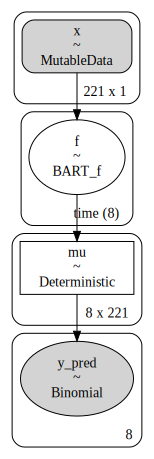

In [166]:
pm.model_to_graphviz(bart)

In [274]:
hz = bdata.posterior.mu.mean(("chain", "draw", "mu_dim_1")).values

SV = (1-hz).cumprod()

In [275]:
pp.posterior_predictive.mu.mean(("chain", "draw"))

<xarray.DataArray 'mu' (mu_dim_2: 8, mu_dim_3: 16)>
array([[0.90941017, 0.90941017, 0.90941017, 0.90941017, 0.90941017,
        0.90941017, 0.90941017, 0.90941017, 0.22849701, 0.22849701,
        0.22849701, 0.22849701, 0.22849701, 0.22849701, 0.22849701,
        0.22849701],
       [0.91033456, 0.91033456, 0.91033456, 0.91033456, 0.91033456,
        0.91033456, 0.91033456, 0.91033456, 0.06737695, 0.06737695,
        0.06737695, 0.06737695, 0.06737695, 0.06737695, 0.06737695,
        0.06737695],
       [0.99810752, 0.99810752, 0.99810752, 0.99810752, 0.99810752,
        0.99810752, 0.99810752, 0.99810752, 0.00956   , 0.00956   ,
        0.00956   , 0.00956   , 0.00956   , 0.00956   , 0.00956   ,
        0.00956   ],
       [0.87121709, 0.87121709, 0.87121709, 0.87121709, 0.87121709,
        0.87121709, 0.87121709, 0.87121709, 0.07084674, 0.07084674,
        0.07084674, 0.07084674, 0.07084674, 0.07084674, 0.07084674,
        0.07084674],
       [0.48657237, 0.48657237, 0.48657237, 0.48657237, 0.48657237,
        0.48657237, 0.48657237, 0.48657237, 0.50325837, 0.50325837,
        0.50325837, 0.50325837, 0.50325837, 0.50325837, 0.50325837,
        0.50325837],
       [0.02945506, 0.02945506, 0.02945506, 0.02945506, 0.02945506,
        0.02945506, 0.02945506, 0.02945506, 0.98791005, 0.98791005,
        0.98791005, 0.98791005, 0.98791005, 0.98791005, 0.98791005,
        0.98791005],
       [0.53067007, 0.53067007, 0.53067007, 0.53067007, 0.53067007,
        0.53067007, 0.53067007, 0.53067007, 0.44880021, 0.44880021,
        0.44880021, 0.44880021, 0.44880021, 0.44880021, 0.44880021,
        0.44880021],
       [0.90440063, 0.90440063, 0.90440063, 0.90440063, 0.90440063,
        0.90440063, 0.90440063, 0.90440063, 0.98810519, 0.98810519,
        0.98810519, 0.98810519, 0.98810519, 0.98810519, 0.98810519,
        0.98810519]])
Coordinates:
  * mu_dim_2  (mu_dim_2) int64 0 1 2 3 4 5 6 7
  * mu_dim_3  (mu_dim_3) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

In [276]:


x0_idx = np.where([b_te_x[:,1] == 1])[1]
x1_idx = np.where([b_te_x[:,1] == 0])[1]
print(x0_idx)
hz0 = pp.posterior_predictive.mu.mean(("chain","draw"))[:,x0_idx].mean("mu_dim_3")
hz1 = pp.posterior_predictive.mu.mean(("chain","draw"))[:,x1_idx].mean("mu_dim_3")

sv0 = np.concatenate([[1], (1-hz0).cumprod().values])
sv1 = np.concatenate([[1], (1-hz1).cumprod().values])



[ 8  9 10 11 12 13 14 15]


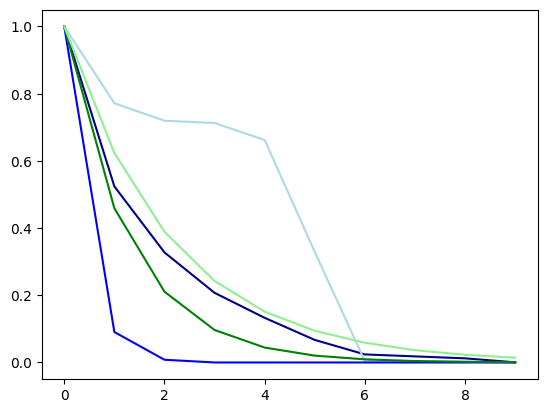

In [277]:
plt.plot(np.concatenate([[0],df_unq]), np.concatenate([[1],SV]), color="darkblue")
plt.plot(np.concatenate([[0],df_unq]), sv0, color="lightblue")
plt.plot(np.concatenate([[0],df_unq]), sv1, color="blue")

plt.plot(T, sv_unique[0], color = "green")
plt.plot(T, sv_unique[1], color = "lightgreen")


# Results
Basically trying to condition on a binomial does not work.
Somehow you can recover the mean, which makes sense, but the individual components don't break apart correctly

In [33]:
x0_sk = y_sk[x_mat[:,0]==0]
x1_sk = y_sk[x_mat[:,0]==1]

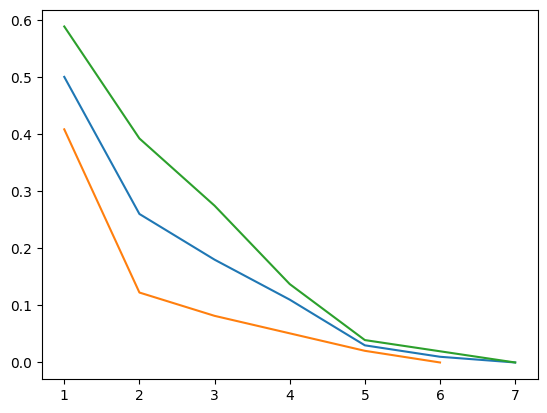

In [37]:
from sksurv.nonparametric import kaplan_meier_estimator


t_f, sv_f, ci_f = kaplan_meier_estimator(
    y_sk["Status"], 
    y_sk["Survival_in_days"], 
    conf_type="log-log"
)

t_f1, sv_f1, ci_f1 = kaplan_meier_estimator(
    x0_sk["Status"], 
    x0_sk["Survival_in_days"], 
    conf_type="log-log"
)

t_f2, sv_f2, ci_f2 = kaplan_meier_estimator(
    x1_sk["Status"], 
    x1_sk["Survival_in_days"], 
    conf_type="log-log"
)

plt.plot(t_f, sv_f)
plt.plot(t_f1, sv_f1)
plt.plot(t_f2, sv_f2)

Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f, y_pred]


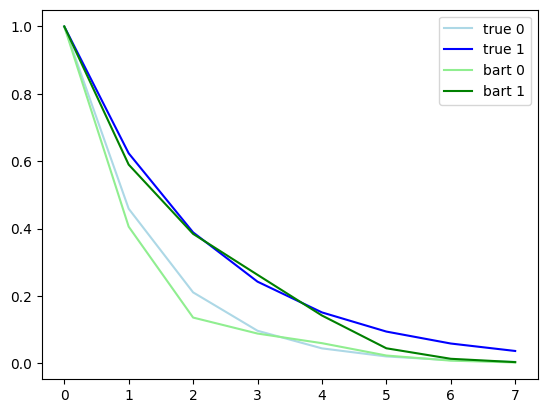

In [16]:

coords = {
    "label":["time", "x"]
}
with pm.Model(coords = coords) as bart:
    bart.add_coord(name = "obs", values= np.arange(0,b_tr_x.shape[0],1), mutable=True)
    x_data = pm.MutableData("x", b_tr_x, dims = ("obs", "label"))
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = [pmb.ContinuousSplitRule(), pmb.OneHotSplitRule()])
    z = pm.Deterministic("z", f + off)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
    bdata = pm.sample(random_seed=2, draws=200, tune = 200, cores=4)
    # post_p = pm.sample_posterior_predictive(bdata)

with bart:
    pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# transform to survival
bart_sv_fx = ssf.get_sv_fx(pp, x_out)
# bart_svt
bart_sv_t = np.unique(b_tr_t)

# add a time 0 with prob 1 
bart_sv_t = np.concatenate([np.array([0]), bart_sv_t])
bart_sv_val = [np.concatenate([np.array([1]), sv]) for sv in bart_sv_fx]


plt.plot(T, sv_unique[0], color= "lightblue", label="true 0")
plt.plot(T, sv_unique[1], color = "blue", label="true 1")
plt.plot(bart_sv_t, bart_sv_val[0], color = "lightgreen", label="bart 0")
plt.plot(bart_sv_t, bart_sv_val[1], color = "green", label="bart 1")
# plt.plot(t_f, sv_f)
plt.plot(t_f1, sv_f1, color="red")
plt.plot(t_f2, sv_f2, color="pink")
plt.legend()

In [61]:
import sksurv.linear_model

cph = sks.linear_model.CoxPHSurvivalAnalysis().fit(x_sk, y_sk)
cph_sv = cph.predict_survival_function(np.unique(x_mat, axis=0))

cph_sv_val = [fn(fn.x) for fn in cph_sv]
cph_sv_val = [np.hstack([1, sv]) for sv in cph_sv_val]
cph_t = np.hstack([0, [fn.x for fn in cph_sv][0]])



/home/twj8/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


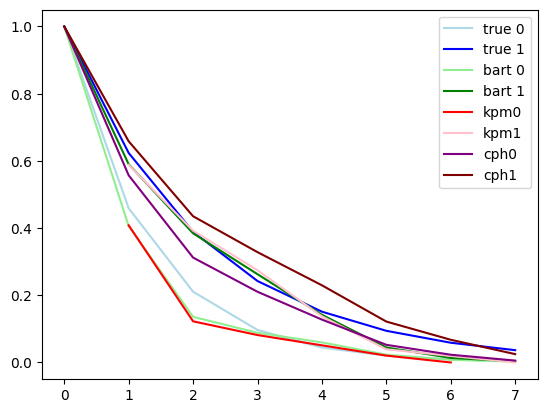

In [65]:

plt.plot(T, sv_unique[0], color= "lightblue", label="true 0")
plt.plot(T, sv_unique[1], color = "blue", label="true 1")
plt.plot(bart_sv_t, bart_sv_val[0], color = "lightgreen", label="bart 0")
plt.plot(bart_sv_t, bart_sv_val[1], color = "green", label="bart 1")
# plt.plot(t_f, sv_f)
plt.plot(t_f1, sv_f1, color="red", label="kpm0")
plt.plot(t_f2, sv_f2, color="pink", label="kpm1")
plt.plot(cph_t, cph_sv_val[0], color="purple", label = "cph0")
plt.plot(cph_t, cph_sv_val[1], color="maroon", label="cph1")
plt.legend()

In [282]:
bdata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

/home/twj8/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/twj8/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


array([<AxesSubplot:xlabel='X_0'>, <AxesSubplot:xlabel='X_1'>],
      dtype=object)

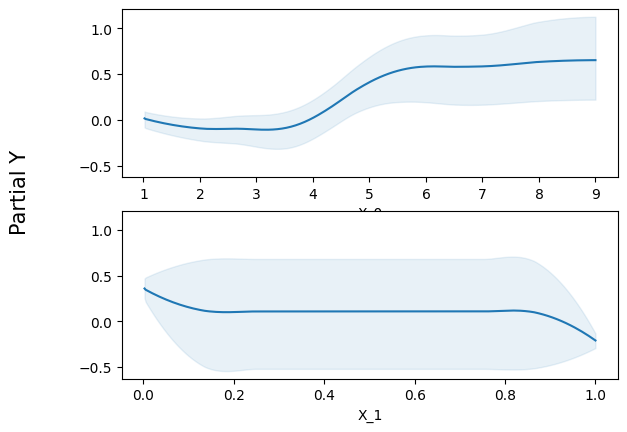

In [220]:
pmb.plot_pdp(f, b_tr_x)

/home/twj8/.local/lib/python3.10/site-packages/pymc_bart/utils.py:778: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  chains_hdi = az.hdi((var_imp_chains.T / var_imp_chains.sum(axis=1)).T)[indices]


(array([0, 1]),
 array([<AxesSubplot:xlabel='covariables', ylabel='importance'>,
        <AxesSubplot:xlabel='number of covariables', ylabel='R²'>],
       dtype=object))

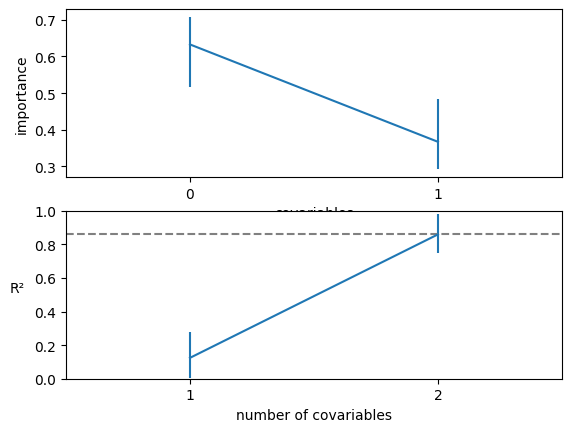

In [221]:
pmb.plot_variable_importance(bdata, f, b_tr_x, samples=100)

# coords example

In [18]:
df_rugby = pd.read_csv(pm.get_data('rugby.csv'), index_col=0)
home_idx, teams = pd.factorize(df_rugby["home_team"], sort=True)
away_idx, _ = pd.factorize(df_rugby["away_team"], sort=True)

In [25]:
print(home_idx)
print(teams)
print(away_idx)
df_rugby

[5 1 2 2 4 1 5 3 0 2 4 0 3 5 1 5 3 1 0 2 4 4 1 2 5 0 3 3 4 0 1 4 2 1 5 3 5
 3 0 2 0 4 5 2 1 4 0 3 3 5 1 4 2 0 5 3 0 4 1 2]
Index(['England', 'France', 'Ireland', 'Italy', 'Scotland', 'Wales'], dtype='object')
[3 0 4 5 0 3 1 4 2 3 1 5 0 4 2 0 2 4 3 1 5 3 5 0 2 4 1 5 2 1 3 0 5 2 4 0 1
 4 2 3 5 1 3 4 0 2 1 5 2 0 4 5 1 3 2 1 4 3 5 0]


,home_team,away_team,home_score,away_score,year
0,Wales,Italy,23,15,2014
1,France,England,26,24,2014
2,Ireland,Scotland,28,6,2014
3,Ireland,Wales,26,3,2014
4,Scotland,England,0,20,2014
5,France,Italy,30,10,2014
6,Wales,France,27,6,2014
7,Italy,Scotland,20,21,2014
8,England,Ireland,13,10,2014
9,Ireland,Italy,46,7,2014


In [109]:
df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

In [110]:
coords = {
    "team": teams,
    "match": np.arange(60),
    "field": ["home", "away"],
}
with pm.Model(coords=coords) as rugby_model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Flat('intercept')

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic('atts', atts_star - atts_star.mean(), dims="team")
    defs = pm.Deterministic('defs', defs_star - defs_star.mean(), dims="team")
    home_theta = tt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = tt.exp(intercept + atts[away_idx] + defs[home_idx])

    print(defs[away_idx])
    print(type(atts_star))
    print(type(home_theta))
    print(str(tt.stack((home_theta, away_theta)).T))
    # likelihood of observed data
    points = pm.Poisson(
        'home_points', 
        mu=tt.stack((home_theta, away_theta)).T, 
        observed=df_rugby[["home_score", "away_score"]],
        dims=("match", "field")
    )
    rugby_trace = pm.sample(1000, tune=1000, cores=4, return_inferencedata=True)

AdvancedSubtensor.0
<class 'pytensor.tensor.var.TensorVariable'>
<class 'pytensor.tensor.var.TensorVariable'>
Transpose{axes=[1, 0]}.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]


ValueError: Not enough samples to build a trace.

In [129]:
atts[home_idx]

AdvancedSubtensor.0

In [121]:
coords = {
    "team": teams,
    "match": np.arange(60),
    "field": ["home", "away"],
}
with pm.Model(coords=coords) as model:
    # constant data
    # home_team = pm.Data("home_team", home_idx, dims="match")
    # away_team = pm.Data("away_team", away_idx, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - tt.mean(defs_star), dims="team")
    home_theta = pm.Deterministic("home_theta", tt.exp(intercept + home + atts[home_idx] + defs[away_idx]))
    away_theta = pm.Deterministic("away_theta", tt.exp(intercept + atts[away_idx] + defs[home_idx]))

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),
    )
    # trace = pm.sample(1000, tune=1000, cores=4, return_inferencedata=True, target_accept=0.85)

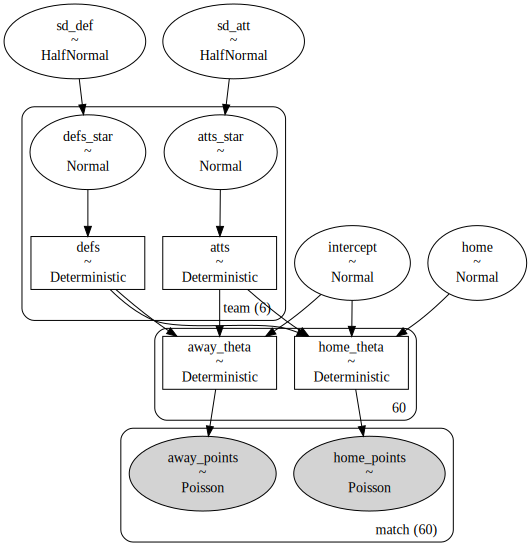

In [122]:
pm.model_to_graphviz(model)

In [117]:
home

home ~ Normal(0, 1)

In [58]:
rugby_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [1]:
import numpy as np

In [9]:
np.quantile([1,2,3,3,3,3], [0.5])

array([3.])

In [166]:
data = pd.read_csv(pm.get_data("efron-morris-75-data.tsv"), sep="\t")
at_bats, hits = data[["At-Bats", "Hits"]].to_numpy().T

In [170]:
N = len(hits)
player_names = data["FirstName"] + " " + data["LastName"]
coords = {"player_names": player_names.tolist()}
coords

{'player_names': ['Roberto Clemente',
  'Frank Robinson',
  'Frank Howard',
  'Jay Johnstone',
  'Ken Berry',
  'Jim Spencer',
  'Don Kessinger',
  'Luis Alvarado',
  'Ron Santo',
  'Ron Swaboda',
  'Rico Petrocelli',
  'Ellie Rodriguez',
  'George Scott',
  'Del Unser',
  'Billy Williams',
  'Bert Campaneris',
  'Thurman Munson',
  'Max Alvis']}

In [171]:
at_bats

array([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45])